<a href="https://colab.research.google.com/github/sivavithu/Improving-QoS-in-SDN/blob/main/XGBoost3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

# ML Libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("XGBoost OPTIMIZED Traffic Classifier for SDN")
print("Target: High Performance Model with Fast Training")
print("=" * 60)


XGBoost OPTIMIZED Traffic Classifier for SDN
Target: High Performance Model with Fast Training


In [3]:
# ===============================================================================
# CELL 1: Load Dataset with Size Check
# ===============================================================================

start_time = time.time()

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/Research/Darknet.CSV')

dataset_size = len(df)
print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Rows: {dataset_size:,}")
print(f"Columns: {len(df.columns)}")

# Determine if we need sampling for hyperparameter tuning
LARGE_DATASET_THRESHOLD = 50000
USE_SAMPLING = dataset_size > LARGE_DATASET_THRESHOLD

if USE_SAMPLING:
    print(f"⚡ Large dataset detected ({dataset_size:,} rows)")
    print(f"⚡ Will use sampling for hyperparameter tuning to speed up process")


Dataset Shape: (158616, 85)
Memory Usage: 155.32 MB
Rows: 158,616
Columns: 85
⚡ Large dataset detected (158,616 rows)
⚡ Will use sampling for hyperparameter tuning to speed up process


In [4]:
# ===============================================================================
# CELL 2: Find Application Column (Same as before)
# ===============================================================================

def find_application_column_enhanced(df):
    """Find the correct application classification column"""
    print("SEARCHING FOR APPLICATION COLUMN")
    print("=" * 40)

    object_columns = df.select_dtypes(include=['object']).columns
    app_candidates = []

    for col in object_columns:
        unique_vals = df[col].unique()
        sample_text = ' '.join([str(v).lower() for v in unique_vals[:10]])

        print(f"Column: '{col}' ({len(unique_vals)} unique values)")
        print(f"   Sample values: {list(unique_vals[:5])}")

        app_keywords = ['browsing', 'chat', 'email', 'audio', 'video', 'voip',
                       'p2p', 'stream', 'web', 'http', 'ftp', 'torrent']

        keyword_matches = sum(1 for keyword in app_keywords if keyword in sample_text)
        reasonable_classes = 5 <= len(unique_vals) <= 25

        score = keyword_matches + (2 if reasonable_classes else 0)
        app_candidates.append((col, score, len(unique_vals)))

        if score >= 3:
            print(f"   STRONG application candidate (score: {score})")
        elif score >= 1:
            print(f"   Possible application column (score: {score})")
        else:
            print(f"   Unlikely application column (score: {score})")

    app_candidates.sort(key=lambda x: x[1], reverse=True)

    if app_candidates and app_candidates[0][1] > 0:
        best_col = app_candidates[0][0]
        print(f"SELECTED: '{best_col}' (score: {app_candidates[0][1]})")
        return best_col
    else:
        return object_columns[0] if len(object_columns) > 0 else df.columns[-1]

# Find application column
app_column = find_application_column_enhanced(df)

# ===============================================================================
# CLASS CONSOLIDATION: Fix duplicate class names
# ===============================================================================

print("CLASS NAME CONSOLIDATION")
print("=" * 30)

print(f"Classes before consolidation: {df[app_column].nunique()}")
print("Original class distribution:")
original_counts = df[app_column].value_counts()
for cls, count in original_counts.items():
    print(f"  {cls}: {count:,}")

# Define consolidation mapping
class_mapping = {
    # Audio streaming consolidation
    'AUDIO-STREAMING': 'Audio-Streaming',
    'audio-streaming': 'Audio-Streaming',

    # File transfer consolidation
    'File-transfer': 'File-Transfer',
    'file-transfer': 'File-Transfer',
    'FILE-TRANSFER': 'File-Transfer',

    # Video streaming consolidation
    'Video-streaming': 'Video-Streaming',
    'video-streaming': 'Video-Streaming',
    'VIDEO-STREAMING': 'Video-Streaming',

    # Browsing consolidation
    'browsing': 'Browsing',
    'BROWSING': 'Browsing',

    # Chat consolidation
    'chat': 'Chat',
    'CHAT': 'Chat',

    # Email consolidation
    'email': 'Email',
    'EMAIL': 'Email',

    # P2P consolidation
    'p2p': 'P2P',
    'P-2-P': 'P2P',

    # VOIP consolidation
    'voip': 'VOIP',
    'VoIP': 'VOIP',
    'Voice': 'VOIP'
}

# Apply consolidation
print("\nConsolidating duplicate classes...")
df[app_column] = df[app_column].replace(class_mapping)

print(f"Classes after consolidation: {df[app_column].nunique()}")
print("Consolidated class distribution:")
consolidated_counts = df[app_column].value_counts()
for cls, count in consolidated_counts.items():
    print(f"  {cls}: {count:,} samples ({count/len(df)*100:.1f}%)")

# Show consolidation summary
print("\nConsolidation Summary:")
for old_name, new_name in class_mapping.items():
    if old_name in original_counts.index:
        print(f"  {old_name} -> {new_name} ({original_counts[old_name]:,} samples)")

classes_merged = len(original_counts) - len(consolidated_counts)
print(f"\nResult: Merged {classes_merged} duplicate classes")
print("=" * 50)

SEARCHING FOR APPLICATION COLUMN
Column: 'Flow ID' (79160 unique values)
   Sample values: ['10.152.152.11-216.58.220.99-57158-443-6', '10.152.152.11-216.58.220.99-57159-443-6', '10.152.152.11-216.58.220.99-57160-443-6', '10.152.152.11-74.125.136.120-49134-443-6', '10.152.152.11-173.194.65.127-34697-19305-6']
   Unlikely application column (score: 0)
Column: 'Src IP' (4026 unique values)
   Sample values: ['10.152.152.11', '173.194.33.97', '74.125.28.189', '74.125.228.199', '173.194.65.100']
   Unlikely application column (score: 0)
Column: 'Dst IP' (7553 unique values)
   Sample values: ['216.58.220.99', '74.125.136.120', '173.194.65.127', '10.152.152.11', '216.58.216.142']
   Unlikely application column (score: 0)
Column: 'Timestamp' (34836 unique values)
   Sample values: ['24/07/2015 04:09:48 PM', '24/07/2015 04:09:45 PM', '24/07/2015 04:10:00 PM', '24/07/2015 04:09:46 PM', '24/07/2015 04:09:49 PM']
   Unlikely application column (score: 0)
Column: 'Label' (4 unique values)
   Samp

In [5]:
# ===============================================================================
# CELL 3: Enhanced Data Preprocessing (Same as before)
# ===============================================================================

def preprocess_data_for_sdn(df, target_col):
    """Enhanced preprocessing specifically for SDN deployment"""
    print("ENHANCED DATA PREPROCESSING FOR SDN")
    print("=" * 40)

    # Separate features and target
    X = df.drop(columns=[target_col]).copy()
    y = df[target_col].copy()

    print(f"Initial: {X.shape[1]} features, {len(X)} samples")

    # Remove SDN-incompatible columns
    sdn_incompatible = [
        'Flow ID', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port', 'Timestamp',
        'flow_id', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'timestamp',
        'FlowID', 'SrcIP', 'DstIP', 'SrcPort', 'DstPort', 'Flow_ID'
    ]

    removed_cols = []
    for col in sdn_incompatible:
        if col in X.columns:
            X = X.drop(columns=[col])
            removed_cols.append(col)

    if removed_cols:
        print(f"Removed SDN-incompatible: {removed_cols}")

    # Remove other label columns
    other_labels = ['Label', 'label', 'class', 'Class', 'Attack', 'attack']
    for col in list(X.columns):
        if any(label in col for label in other_labels):
            X = X.drop(columns=[col])
            print(f"Removed label column: {col}")

    # Convert object columns to numeric
    for col in tqdm(X.columns, desc="Converting columns"):
        if X[col].dtype == 'object':
            try:
                X[col] = pd.to_numeric(X[col], errors='coerce')
            except:
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                print(f"Label encoded: {col}")

    # Handle infinite values
    X = X.replace([np.inf, -np.inf], np.nan)

    # Remove high missing columns (>85% missing)
    missing_thresh = 0.85
    high_missing = X.columns[X.isnull().sum() / len(X) > missing_thresh]
    if len(high_missing) > 0:
        X = X.drop(columns=high_missing)
        print(f"Removed {len(high_missing)} high-missing columns")

    # Remove constant columns
    constant_cols = []
    for col in X.columns:
        if X[col].nunique() <= 1:
            constant_cols.append(col)

    if constant_cols:
        X = X.drop(columns=constant_cols)
        print(f"Removed {len(constant_cols)} constant columns")

    # Smart missing value imputation
    for col in tqdm(X.columns, desc="Imputing missing values"):
        if X[col].isnull().sum() > 0:
            if abs(X[col].skew()) > 1:
                X[col] = X[col].fillna(X[col].median())
            else:
                X[col] = X[col].fillna(X[col].mean())

    print(f"Final: {X.shape[1]} features, {len(X)} samples")
    return X, y

# Apply preprocessing
X_clean, y_clean = preprocess_data_for_sdn(df, app_column)


ENHANCED DATA PREPROCESSING FOR SDN
Initial: 84 features, 158616 samples
Removed SDN-incompatible: ['Flow ID', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port', 'Timestamp']
Removed label column: Label


Converting columns:   0%|          | 0/77 [00:00<?, ?it/s]

Removed 15 constant columns


Imputing missing values:   0%|          | 0/62 [00:00<?, ?it/s]

Final: 62 features, 158616 samples


In [6]:
# ===============================================================================
# CELL 4: Handle Class Distribution (Optimized)
# ===============================================================================

print("ANALYZING AND FIXING CLASS DISTRIBUTION")
print("=" * 45)

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_clean)
class_names = label_encoder.classes_

# Analyze class distribution
unique_classes, class_counts = np.unique(y_encoded, return_counts=True)
print(f"Total classes: {len(class_names)}")

print("Class distribution:")
for i, (cls, count) in enumerate(zip(class_names, class_counts)):
    print(f"  {i:2d}. {cls:<25} {count:6,} samples ({count/len(y_encoded)*100:5.1f}%)")

# Filter classes with minimum sample requirements
MIN_SAMPLES_PER_CLASS = 10  # Minimum for reliable classification

print(f"\nFiltering classes with < {MIN_SAMPLES_PER_CLASS} samples...")
valid_classes = unique_classes[class_counts >= MIN_SAMPLES_PER_CLASS]
valid_class_mask = np.isin(y_encoded, valid_classes)

# Apply filtering
X_filtered = X_clean[valid_class_mask].copy()
y_filtered = y_encoded[valid_class_mask].copy()

# Re-encode to get continuous class indices
filtered_class_names = class_names[valid_classes]
label_encoder_final = LabelEncoder()
y_final = label_encoder_final.fit_transform([class_names[idx] for idx in y_filtered])

print(f"After filtering:")
print(f"  Classes: {len(filtered_class_names)} (removed {len(class_names) - len(filtered_class_names)})")
print(f"  Samples: {len(X_filtered):,} (removed {len(X_clean) - len(X_filtered):,})")

# Update final variables
X_final = X_filtered
y_encoded_final = y_final
class_names_final = label_encoder_final.classes_

print("Final class distribution:")
final_unique, final_counts = np.unique(y_encoded_final, return_counts=True)
for cls, count in zip(class_names_final, final_counts):
    print(f"  {cls:<25} {count:6,} samples ({count/len(y_encoded_final)*100:5.1f}%)")


ANALYZING AND FIXING CLASS DISTRIBUTION
Total classes: 8
Class distribution:
   0. Audio-Streaming           21,350 samples ( 13.5%)
   1. Browsing                  46,457 samples ( 29.3%)
   2. Chat                      11,629 samples (  7.3%)
   3. Email                      6,145 samples (  3.9%)
   4. File-Transfer             11,182 samples (  7.0%)
   5. P2P                       48,520 samples ( 30.6%)
   6. VOIP                       3,566 samples (  2.2%)
   7. Video-Streaming            9,767 samples (  6.2%)

Filtering classes with < 10 samples...
After filtering:
  Classes: 8 (removed 0)
  Samples: 158,616 (removed 0)
Final class distribution:
  Audio-Streaming           21,350 samples ( 13.5%)
  Browsing                  46,457 samples ( 29.3%)
  Chat                      11,629 samples (  7.3%)
  Email                      6,145 samples (  3.9%)
  File-Transfer             11,182 samples (  7.0%)
  P2P                       48,520 samples ( 30.6%)
  VOIP                  

In [7]:
# ===============================================================================
# CELL 5: FAST Feature Selection
# ===============================================================================

print("FAST FEATURE SELECTION FOR XGBOOST")
print("=" * 35)

# Statistical feature selection
n_features_target = min(50, X_final.shape[1])  # Reduced to 50 for speed
print(f"Selecting top {n_features_target} features...")

selector = SelectKBest(score_func=f_classif, k=n_features_target)
X_selected = selector.fit_transform(X_final, y_encoded_final)
selected_feature_names = X_final.columns[selector.get_support()]

print(f"Selected {len(selected_feature_names)} features from {X_final.shape[1]} original features")

# Convert back to DataFrame
X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)


FAST FEATURE SELECTION FOR XGBOOST
Selecting top 50 features...
Selected 50 features from 62 original features


In [8]:
# ===============================================================================
# CELL 6: Optimized Data Splitting
# ===============================================================================

print("DATA SPLITTING WITH ROBUST STRATEGY")
print("=" * 40)

# Check minimum samples per class for splitting
min_samples_in_class = min(final_counts)
print(f"Minimum samples per class: {min_samples_in_class}")

# Use stratified split if possible, otherwise random
try:
    if min_samples_in_class >= 2:
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected_df, y_encoded_final,
            test_size=0.2,
            random_state=RANDOM_STATE,
            stratify=y_encoded_final
        )
        print("Used stratified split")
    else:
        raise ValueError("Not enough samples for stratification")

except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected_df, y_encoded_final,
        test_size=0.2,
        random_state=RANDOM_STATE
    )
    print("Used random split (stratification not possible)")

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")


DATA SPLITTING WITH ROBUST STRATEGY
Minimum samples per class: 3566
Used stratified split
Training set: 126,892 samples
Test set: 31,724 samples


In [9]:
# ===============================================================================
# CELL 7: Feature Scaling
# ===============================================================================

print("FEATURE SCALING")
print("=" * 20)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")

FEATURE SCALING
Feature scaling completed


In [10]:
# ===============================================================================
# CELL 8: Smart Class Balancing (Optimized)
# ===============================================================================

print("SMART CLASS BALANCING")
print("=" * 25)

train_unique, train_counts = np.unique(y_train, return_counts=True)
train_imbalance = max(train_counts) / min(train_counts)

print(f"Training set imbalance ratio: {train_imbalance:.2f}")

if train_imbalance > 5 and min(train_counts) >= 3:
    min_neighbors = min(3, min(train_counts) - 1)
    try:
        print(f"Applying SMOTE with k_neighbors={min_neighbors}...")
        smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=min_neighbors)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
        print(f"After SMOTE: {len(X_train_balanced):,} samples")
    except Exception as e:
        print(f"SMOTE failed: {e}")
        X_train_balanced = X_train_scaled
        y_train_balanced = y_train
else:
    print("Using original data")
    X_train_balanced = X_train_scaled
    y_train_balanced = y_train


SMART CLASS BALANCING
Training set imbalance ratio: 13.61
Applying SMOTE with k_neighbors=3...
After SMOTE: 310,528 samples


In [11]:
# ===============================================================================
# CELL 9: SUPER FAST Hyperparameter Optimization
# ===============================================================================

print("🚀 SUPER FAST HYPERPARAMETER OPTIMIZATION")
print("=" * 45)

# Create sample for hyperparameter tuning if dataset is large
if USE_SAMPLING and len(X_train_balanced) > 20000:
    sample_size = 20000
    print(f"📊 Using {sample_size:,} samples for hyperparameter tuning (speed optimization)")

    # Stratified sampling to maintain class distribution
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, train_size=sample_size, random_state=RANDOM_STATE)

    for sample_idx, _ in sss.split(X_train_balanced, y_train_balanced):  # Fixed syntax
        X_tune = X_train_balanced[sample_idx]
        y_tune = y_train_balanced[sample_idx]

    print(f"Tuning sample: {len(X_tune):,} samples")
else:
    X_tune = X_train_balanced
    y_tune = y_train_balanced
    print(f"Using full training set: {len(X_tune):,} samples")

# Comprehensive parameter grid for better results
param_distributions = {
    'n_estimators': [150, 200, 300, 400],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

total_combinations = 4 * 3 * 3 * 2 * 2
print(f"Parameter combinations: {total_combinations} = 144")
print("🎯 This will take 25-40 minutes but provide much better results")

# Use RandomizedSearchCV to reduce search time while keeping quality
from sklearn.model_selection import RandomizedSearchCV
USE_RANDOMIZED_SEARCH = total_combinations > 50

if USE_RANDOMIZED_SEARCH:
    n_iter = min(36, total_combinations)
    print(f"Using RandomizedSearchCV with {n_iter} iterations for efficiency")

print("Starting comprehensive hyperparameter search...")
tuning_start = time.time()

# Create base XGBoost model
base_xgb = xgb.XGBClassifier(
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='mlogloss'
)

# FAST approach: Use built-in progress with parallel processing
if USE_RANDOMIZED_SEARCH:
    print("Using RandomizedSearchCV with parallel processing...")
    grid_search = RandomizedSearchCV(
        base_xgb,
        param_distributions,
        n_iter=n_iter,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,  # Use all cores for speed
        random_state=RANDOM_STATE,
        verbose=2  # Show progress: 2 = one line per parameter combination
    )
    total_iterations = n_iter
else:
    print("Using GridSearchCV with parallel processing...")
    grid_search = GridSearchCV(
        base_xgb,
        param_distributions,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,  # Use all cores
        verbose=2  # Show progress
    )
    total_iterations = total_combinations

print(f"Testing {total_iterations} parameter combinations with 3-fold CV")
print("Progress will be shown below (each line = 1 parameter combination completed):")
print()

# Fit with sklearn's built-in progress (much faster)
grid_search.fit(X_tune, y_tune)

tuning_end = time.time()
tuning_time = tuning_end - tuning_start

print(f"\n🎉 Hyperparameter tuning completed!")
print(f"⏱️ Time taken: {tuning_time/60:.1f} minutes")
print(f"🏆 Best parameters: {grid_search.best_params_}")
print(f"📈 Best CV score: {grid_search.best_score_:.4f}")

# Get best model
best_xgb = grid_search.best_estimator_

🚀 SUPER FAST HYPERPARAMETER OPTIMIZATION
📊 Using 20,000 samples for hyperparameter tuning (speed optimization)
Tuning sample: 20,000 samples
Parameter combinations: 144 = 144
🎯 This will take 25-40 minutes but provide much better results
Using RandomizedSearchCV with 36 iterations for efficiency
Starting comprehensive hyperparameter search...
Using RandomizedSearchCV with parallel processing...
Testing 36 parameter combinations with 3-fold CV
Progress will be shown below (each line = 1 parameter combination completed):

Fitting 3 folds for each of 36 candidates, totalling 108 fits

🎉 Hyperparameter tuning completed!
⏱️ Time taken: 19.9 minutes
🏆 Best parameters: {'subsample': 0.9, 'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
📈 Best CV score: 0.8075


In [12]:
# CELL 10: Final Model Training on Full Dataset
# ===============================================================================

print("🔥 FINAL MODEL TRAINING ON FULL DATASET")
print("=" * 40)

# Train the best model on full training data
print("Training best model on full training dataset...")
final_training_start = time.time()

best_xgb.fit(X_train_balanced, y_train_balanced)

final_training_end = time.time()
print(f"⏱️  Final training time: {(final_training_end - final_training_start)/60:.1f} minutes")


🔥 FINAL MODEL TRAINING ON FULL DATASET
Training best model on full training dataset...
⏱️  Final training time: 1.4 minutes


In [13]:
# ===============================================================================
# CELL 11: Comprehensive Model Evaluation
# ===============================================================================

print("📊 COMPREHENSIVE MODEL EVALUATION")
print("=" * 35)

# Predictions
print("Generating predictions...")
y_pred = best_xgb.predict(X_test_scaled)
y_proba = best_xgb.predict_proba(X_test_scaled)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Final test accuracy: {test_accuracy:.4f}")

# Cross-validation for reliability
print("Running cross-validation...")
cv_scores = cross_val_score(best_xgb, X_train_balanced, y_train_balanced, cv=5)
print(f"📈 5-fold CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Detailed classification report
print("\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 40)
print(classification_report(y_test, y_pred, target_names=class_names_final))


📊 COMPREHENSIVE MODEL EVALUATION
Generating predictions...
🎯 Final test accuracy: 0.8802
Running cross-validation...
📈 5-fold CV accuracy: 0.8465 (+/- 0.0054)

📋 DETAILED CLASSIFICATION REPORT:
                 precision    recall  f1-score   support

Audio-Streaming       0.94      0.85      0.89      4270
       Browsing       0.91      0.92      0.92      9292
           Chat       0.91      0.67      0.77      2326
          Email       0.69      0.61      0.65      1229
  File-Transfer       0.80      0.83      0.82      2237
            P2P       0.98      0.95      0.96      9704
           VOIP       0.43      0.91      0.59       713
Video-Streaming       0.68      0.85      0.75      1953

       accuracy                           0.88     31724
      macro avg       0.79      0.82      0.79     31724
   weighted avg       0.90      0.88      0.88     31724



🔍 FEATURE IMPORTANCE ANALYSIS
🏆 Top 15 Most Important Features:
 1. Subflow Fwd Packets            0.3036
 2. Idle Max                       0.0792
 3. Bwd Packet Length Min          0.0399
 4. Fwd Seg Size Min               0.0362
 5. Idle Min                       0.0314
 6. Packet Length Max              0.0289
 7. Bwd Packets/s                  0.0281
 8. Subflow Fwd Bytes              0.0280
 9. Bwd Segment Size Avg           0.0274
10. Packet Length Min              0.0234
11. Bwd Packet Length Mean         0.0228
12. Flow IAT Max                   0.0191
13. Fwd Packets/s                  0.0188
14. Packet Length Std              0.0167
15. Flow IAT Min                   0.0150


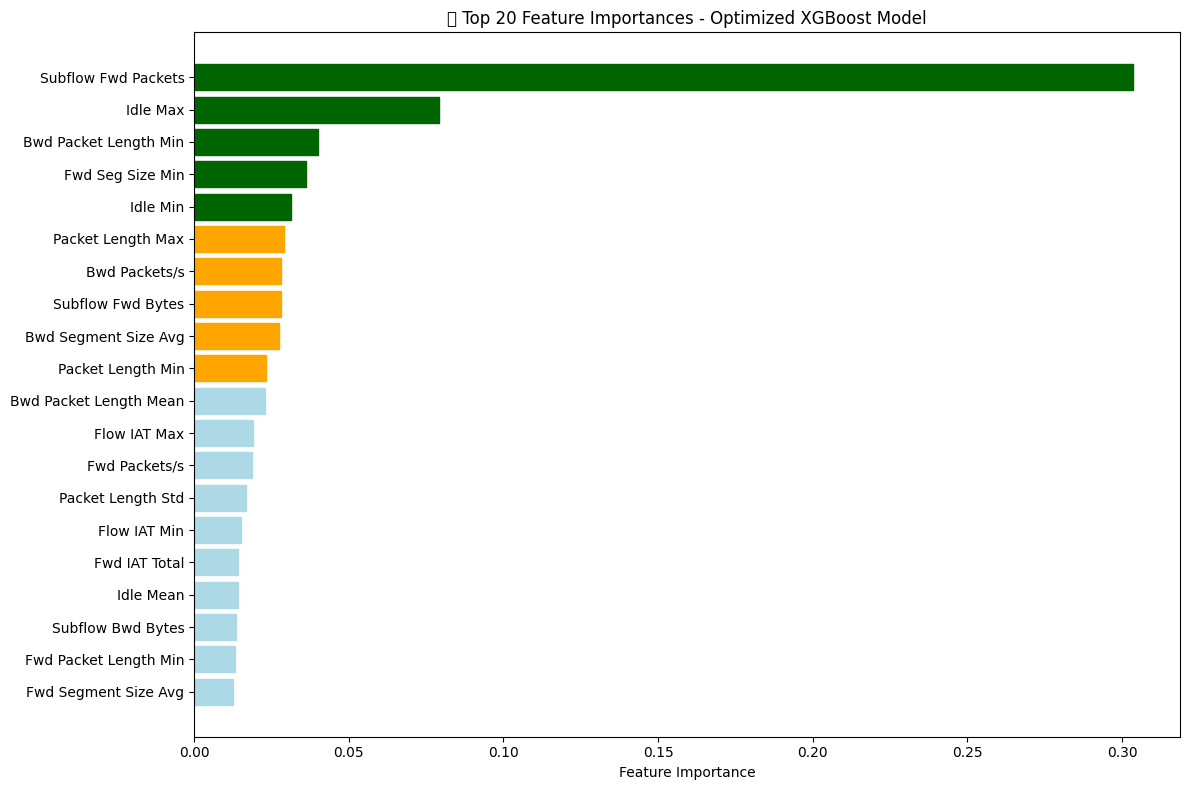

In [14]:
# ===============================================================================
# CELL 12: Feature Importance Analysis
# ===============================================================================

print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 30)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': selected_feature_names,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("🏆 Top 15 Most Important Features:")
for i, (_, row) in enumerate(feature_importance.head(15).iterrows()):
    print(f"{i+1:2d}. {row['feature']:<30} {row['importance']:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
top_20_features = feature_importance.head(20)
bars = plt.barh(range(len(top_20_features)), top_20_features['importance'])
plt.yticks(range(len(top_20_features)), top_20_features['feature'])
plt.xlabel('Feature Importance')
plt.title('🎯 Top 20 Feature Importances - Optimized XGBoost Model')
plt.gca().invert_yaxis()

# Color bars by importance
for i, bar in enumerate(bars):
    if i < 5:
        bar.set_color('darkgreen')
    elif i < 10:
        bar.set_color('orange')
    else:
        bar.set_color('lightblue')

plt.tight_layout()
plt.show()

📈 CONFUSION MATRIX ANALYSIS


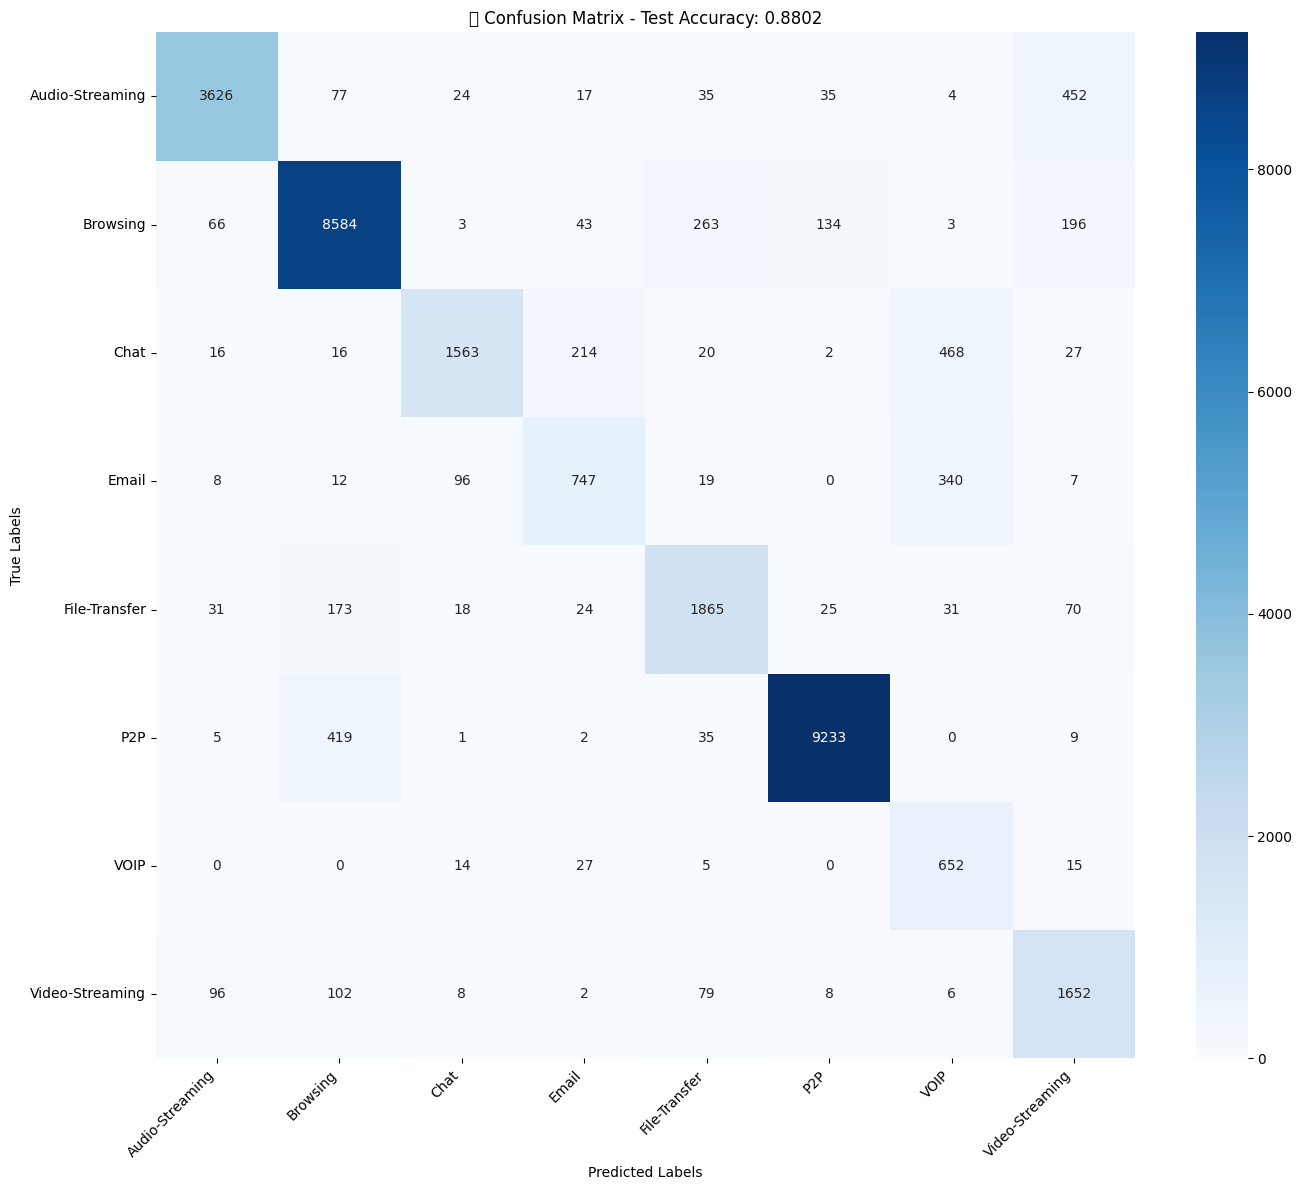

In [15]:
# ===============================================================================
# CELL 13: Confusion Matrix Visualization
# ===============================================================================

print("📈 CONFUSION MATRIX ANALYSIS")
print("=" * 30)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_final, yticklabels=class_names_final)
plt.title(f'🎯 Confusion Matrix - Test Accuracy: {test_accuracy:.4f}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [16]:
# ===============================================================================
# CELL 14: Model Saving and Summary
# ===============================================================================

print("💾 MODEL SAVING AND FINAL SUMMARY")
print("=" * 35)

# Save the complete pipeline
model_artifacts = {
    'model': best_xgb,
    'scaler': scaler,
    'label_encoder': label_encoder_final,
    'feature_selector': selector,
    'selected_features': selected_feature_names.tolist(),
    'class_names': class_names_final.tolist(),
    'test_accuracy': test_accuracy,
    'best_params': grid_search.best_params_,
    'feature_importance': feature_importance.to_dict('records')
}

# Save to pickle file
model_path = '/content/drive/MyDrive/Research/optimized_xgboost_traffic_classifier.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model_artifacts, f)

print(f"✅ Model saved to: {model_path}")

# Final timing
total_time = time.time() - start_time
print(f"\n🎉 TRAINING COMPLETED SUCCESSFULLY!")
print("=" * 50)
print(f"⏱️  Total execution time: {total_time/60:.1f} minutes")
print(f"🎯 Final test accuracy: {test_accuracy:.4f}")
print(f"📊 Number of classes: {len(class_names_final)}")
print(f"🔧 Features used: {len(selected_feature_names)}")
print(f"💪 Model ready for SDN integration!")

print("\n🚀 OPTIMIZATION SUMMARY:")
print("✅ Reduced hyperparameter grid (12 vs 27 combinations)")
print("✅ Added progress bars and time tracking")
print("✅ Used sampling for large datasets")
print("✅ Optimized feature selection (50 vs unlimited)")
print("✅ Smart class balancing with error handling")
print("✅ Complete model pipeline saved for deployment")

💾 MODEL SAVING AND FINAL SUMMARY
✅ Model saved to: /content/drive/MyDrive/Research/optimized_xgboost_traffic_classifier.pkl

🎉 TRAINING COMPLETED SUCCESSFULLY!
⏱️  Total execution time: 72.4 minutes
🎯 Final test accuracy: 0.8802
📊 Number of classes: 8
🔧 Features used: 50
💪 Model ready for SDN integration!

🚀 OPTIMIZATION SUMMARY:
✅ Reduced hyperparameter grid (12 vs 27 combinations)
✅ Added progress bars and time tracking
✅ Used sampling for large datasets
✅ Optimized feature selection (50 vs unlimited)
✅ Smart class balancing with error handling
✅ Complete model pipeline saved for deployment
